## ARM and Networking

### About the model
Association rule mining/learning is used to find relationships of interest among variables in big data sets. We learnt in class that's ARM is most often used for transactional data. To illustrate this further - if we have 10 rows with items separated by commas, ARM will look for patterns of when separate items are bought together, helping us infer the relationships between items. A use case could be: you are trying to market beer to shoppers but don't know where to place it in the store. With a little association rule mining, you learn that beer is often bought with diapers, so you decide to place the beer section closer to the diapers.

For this project, I won't be using ARM for transaction data. Instead, I will be using it to find relationships between text data. Using ARM, we can find the most often used words and the web that interconnects them all. Although this won't lead to predictions, it can help us understand relationships between words; this could lead to new ways of looking at the content of the book.

### Data used

The data I'll be using comes from the Wikipedia parse I did in one of the other model's section. To work with it, I'll have to process it by removing stop words, lemmatizing, stemming, and then tokenizing. For the uninitiated, I'll explain what each of those terms mean. Stop words are words that carry no importance or significance when it comes to understanding the content of a text (i.e. the, is, are). We want to remove them so we can focus on the text that carries more meaning. Lemmatizing reduces the words to their singular form, so we can analyze them as one item. For example: apples would turn to apple. Stemming reduces the words to their root. So leafs would become leaf and leaves would become leav. And lastly, tokenization is when you reduce your text into the elements of your choice to break text down into understandable parts.

Here is a reminder of what the text data looks like:

In [22]:
# import required libraries
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx
import re

# import the file and see the first 5 lines
texts = pd.read_csv('../data/cleanData/wiki-crawl-results.csv')
texts.head()

,text,label,sentiment
0,south korea japan selected host fifa 31 may 19...,FIFA Qatar,0.0258
1,two asian rival went massive expensive pr blit...,FIFA Qatar,0.6249
2,first world cup hosted one country second 2026...,FIFA Qatar,0.9246
3,199 team attempted qualify 2002 world cup qual...,FIFA Qatar,0.8807
4,four nation qualified final first time china e...,FIFA Qatar,-0.6808


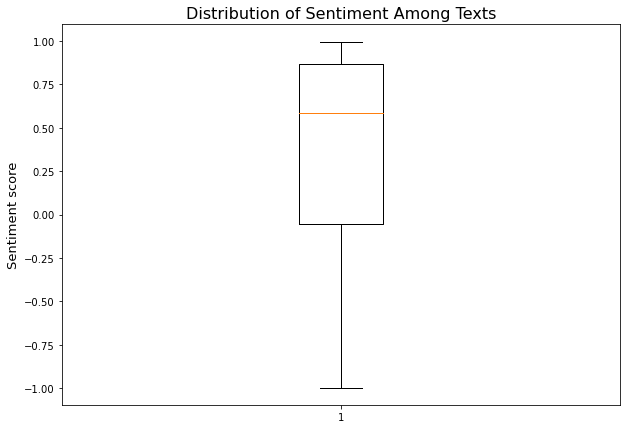

In [23]:
# see the distribution of the sentiment
plt.figure(figsize=(10,7))
plt.boxplot(texts['sentiment'])
plt.ylabel('Sentiment score', fontsize=13)
plt.title('Distribution of Sentiment Among Texts', fontsize=16);

We can appreciate that the average sentiment is quite high (~0.6). It is likely that countries' feelings toward the World Cup tend to be positive and full of excitement.

### Model creation

The model intakes text data in form of a list of list with individual texts separated into words. I took the Wikipedia texts shown above and put them into the required format to work with the `apriori` package. From there, I fed the data to the model and reformatted the result into a dataframe with different metrics (see data frame below for reference). Then I used a function from class that converts the data frame into a network and subsequently into a plot of itself. This all leads to the following frame and plot:

         rhs           lhs      supp      conf  supp X conf      lift
0     [2006]       [world]  0.102683  0.851981     0.087484  1.385711
1    [world]        [2006]  0.102683  0.167009     0.017149  1.385711
2     [2010]       [world]  0.110409  0.878212     0.096962  1.428374
3    [world]        [2010]  0.110409  0.179575     0.019827  1.428374
4     [also]         [cup]  0.141452  0.581409     0.082242  1.087792
..       ...           ...       ...       ...          ...       ...
227  [world]  [tournament]  0.256637  0.417409     0.107123  1.351312
228    [two]       [world]  0.213794  0.694977     0.148582  1.130350
229  [world]         [two]  0.213794  0.347727     0.074342  1.130350
230    [win]       [world]  0.111673  0.727356     0.081226  1.183013
231  [world]         [win]  0.111673  0.181631     0.020283  1.183013

[232 rows x 6 columns]


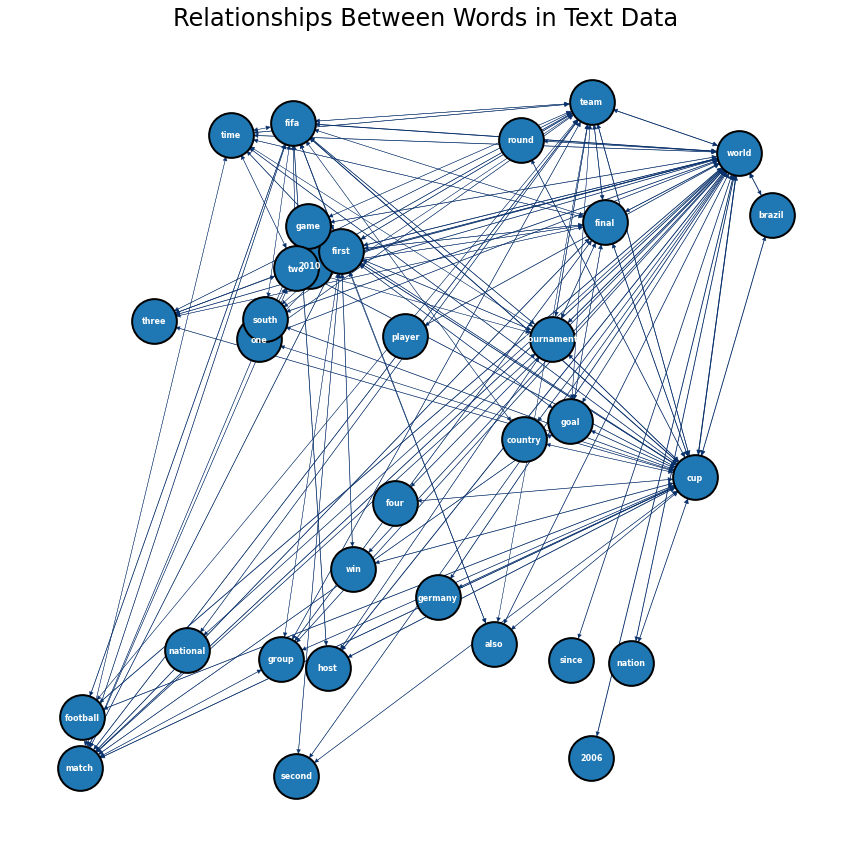

In [44]:
# turn sentences into lists of words and put those lists into a list
sepSent = [text.split() for text in texts['text']]

# results needed for ARM plot
results = list(apriori(sepSent, min_support=0.1, min_confidence=0.1, min_length=1, max_length=2))

### These functions are coming from lab 6.1, I did not write most of them

# reformat the apriori output into a df with columns "rhs", "lhs", "supp", "conf", "supp x conf", "lift"
def reformat_results(results):
    keep=[]
    for i in range(0,len(results)):
        for j in range(0,len(list(results[i]))):
            if(j>1):
                for k in range(0, len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns=['rhs','lhs','supp','conf','supp X conf','lift'])

def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    #ax.set(title='FIFA World Cup')
    plt.title('Relationships Between Words in Text Data', fontsize=24)
    plt.show()

# this code plots the resulting relationships
pd_results=reformat_results(results)
G=convert_to_network(pd_results)
plot_network(G)

### Results
For our relationship web, we see the most common words from the texts and their relationships to each other. It makes perfect sense that Wikipedia text samples regarding each participating team and their involvemnet in the World Cup would result in seeing words such as: cup, group, host, football, match, etc. It seems that the words fifa, team, world, cup, football, and match are the ones that most often coccur with other words. Although this graphs shows the relationships between words at the most general level, it could be useful to search for the relationships between specific words to understand the sentiment behind certain topics. For example, we could take Mexico and see if it leads us to words such as win or lose.

### Conclusion
Using ARM to see how your text data is interconnected can be a fun experiment, and probably a useful one in certain cases. That being said, my goal for this project is to create a model that can predict team performance in the World Cup, so this type of model is not the way to go. Despite this not bein a proper method for my problem, it could be useful for transaction data (as previously mentioned) or perhaps with text from a book. Creating such a plot could lead to understanding the themes from the story and also the words most often associated with certain characters.